In [1]:
import pandas as pd, matplotlib.pyplot as plt, re
from sklearn.preprocessing import LabelEncoder

df = pd.read_json('Data/transactions.txt', lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

#### There are no NA values in the dataset that we need to impute/account for

In [2]:
df.isna().sum()

accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [3]:
df.nunique()

accountNumber                 5000
customerId                    5000
creditLimit                     10
availableMoney              521915
transactionDateTime         776637
transactionAmount            66038
merchantName                  2490
acqCountry                       5
merchantCountryCode              5
posEntryMode                     6
posConditionCode                 4
merchantCategoryCode            19
currentExpDate                 165
accountOpenDate               1820
dateOfLastAddressChange       2184
cardCVV                        899
enteredCVV                     976
cardLast4Digits               5245
transactionType                  4
echoBuffer                       1
currentBalance              487318
merchantCity                     1
merchantState                    1
merchantZip                      1
cardPresent                      2
posOnPremises                    1
recurringAuthInd                 1
expirationDateKeyInMatch         2
isFraud             

### Engineer some time-dependent features and one for anamolous card-entry

In [4]:
def add_time_dependent_features(df, col, include_time_fields=False):
    df[col+'Year'] = df[col].dt.year
    df[col+'Month'] = df[col].dt.month
    df[col+'Day'] = df[col].dt.day
    df[col+'DayOfWeek'] = df[col].dt.weekday
    if include_time_fields:
        df[col+'Hour'] = df[col].dt.hour
        df[col+'Min'] = df[col].dt.minute
    df = df.drop(col, axis=1)
    return df

df['transactionDt'] = pd.to_datetime(df['transactionDateTime'])
add_time_dependent_features(df, 'transactionDt', True)

df['accountOpenDt'] = pd.to_datetime(df['accountOpenDate'])
df = add_time_dependent_features(df, 'accountOpenDt')

df['lastAddressChangeDt'] = pd.to_datetime(df['dateOfLastAddressChange'])
df = add_time_dependent_features(df, 'lastAddressChangeDt')

df['cvvMismatch'] = df['cardCVV']!=df['enteredCVV']

### Remove the features which have just one categorical value

In [5]:
nvalue_counts_df = df.nunique()
columns_to_drop = nvalue_counts_df.index[nvalue_counts_df.values==1]

main_df = df.copy(deep=True)
main_df = main_df.drop(labels=columns_to_drop, axis=1)

### Describe the numerical columns and plot histograms to view distributions
All numerical-features seem to follow a power-distribution. Ignore the master-data fields like customerId, accountNumber, credit-card details, etc.

In [6]:
main_df.describe()

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance,transactionDtMonth,...,transactionDtHour,transactionDtMin,accountOpenDtYear,accountOpenDtMonth,accountOpenDtDay,accountOpenDtDayOfWeek,lastAddressChangeDtYear,lastAddressChangeDtMonth,lastAddressChangeDtDay,lastAddressChangeDtDayOfWeek
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,...,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000,786363.00000
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,136.985791,544.467338,544.183857,4757.417799,4508.739089,6.648343,...,11.511333,29.518682,2013.548618,7.043133,15.917197,3.082027,2014.804087,6.286028,15.476674,2.99443
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,147.725569,261.524220,261.551254,2996.583810,6457.442068,3.436256,...,6.921098,17.325778,1.872314,3.378144,8.752827,1.949832,1.881635,3.373176,8.591262,1.96869
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,0.000000,100.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1989.000000,1.000000,1.000000,0.000000,1989.000000,1.000000,1.000000,0.00000
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,33.650000,310.000000,310.000000,2178.000000,689.910000,4.000000,...,6.000000,15.000000,2013.000000,4.000000,8.000000,1.000000,2014.000000,3.000000,8.000000,1.00000
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,87.900000,535.000000,535.000000,4733.000000,2451.760000,7.000000,...,12.000000,30.000000,2014.000000,7.000000,16.000000,3.000000,2016.000000,6.000000,15.000000,3.00000
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,191.480000,785.000000,785.000000,7338.000000,5291.095000,10.000000,...,18.000000,45.000000,2015.000000,10.000000,23.000000,5.000000,2016.000000,9.000000,23.000000,5.00000
max,9.993896e+08,9.993896e+08,50000.000000,50000.000000,2011.540000,998.000000,998.000000,9998.000000,47498.810000,12.000000,...,23.000000,59.000000,2015.000000,12.000000,31.000000,6.000000,2016.000000,12.000000,31.000000,6.00000


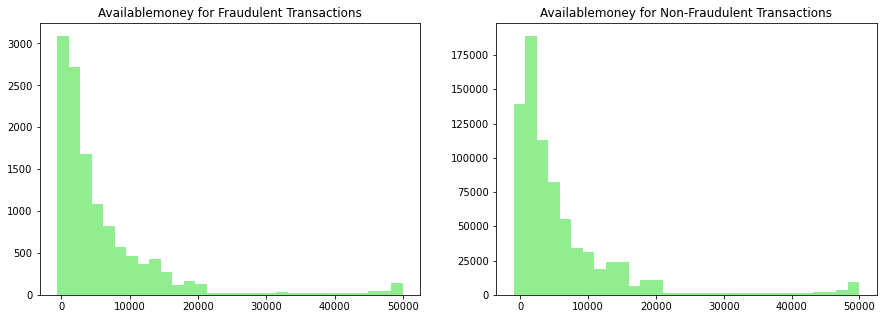

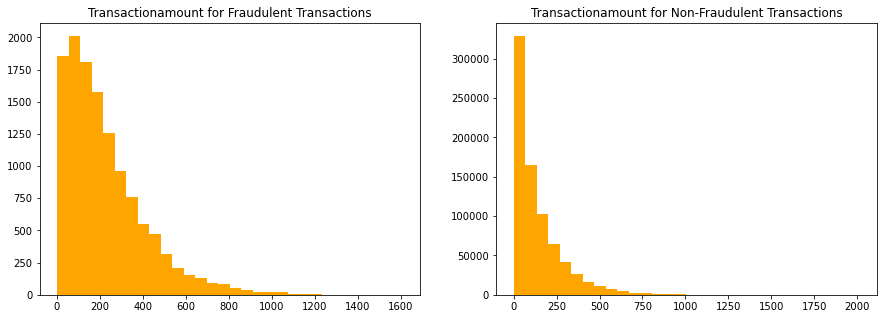

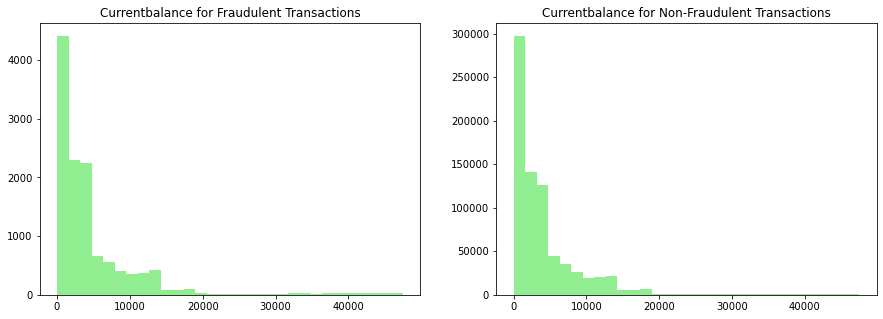

In [7]:
plt.rcParams['figure.figsize'] = (15,5)
numerical_cols = ['availableMoney', 'transactionAmount', 'currentBalance']
colors = ['lightgreen', 'orange']
for i,col in enumerate(numerical_cols):
    fig, ax = plt.subplots(ncols=2)
    
    ax[0].hist(main_df[main_df['isFraud']==True][col], bins=30, color=colors[i%2])
    ax[0].set_title(f'{col.capitalize()} for Fraudulent Transactions')
    
    ax[1].hist(main_df[main_df['isFraud']==False][col], bins=30, color=colors[i%2])
    ax[1].set_title(f'{col.capitalize()} for Non-Fraudulent Transactions')

    plt.show()

### There are just 12,417 cases of Fraud in our dataset of 786,363

In [8]:
count_frauds = main_df['isFraud'].value_counts()
print(f'The dataset contains {round(count_frauds[True]/count_frauds[False]*100,2)}% of fraudulent cases.')

The dataset contains 1.6% of fraudulent cases.


### Replace boolean-values with binary 0/1 instead
If True --> 1, otherwise 0.

In [9]:
boolean_columns = main_df.select_dtypes(include='bool').columns

for col in boolean_columns:
    main_df[col] = main_df[col].replace(True, 1).replace(False, 0)

### Convert categorical columns into one-hot-encodings

In [10]:
categorical_cols = set(main_df.select_dtypes(include='object').columns)
categorical_cols -= set(['transactionDateTime', 'accountOpenDate', 'dateOfLastAddressChange', 'currentExpDate'])
main_df[categorical_cols]

,posConditionCode,merchantName,acqCountry,posEntryMode,merchantCountryCode,transactionType,merchantCategoryCode
0,01,Uber,US,02,US,PURCHASE,rideshare
1,01,AMC #191138,US,09,US,PURCHASE,entertainment
2,01,Play Store,US,09,US,PURCHASE,mobileapps
3,01,Play Store,US,09,US,PURCHASE,mobileapps
4,01,Tim Hortons #947751,US,02,US,PURCHASE,fastfood
...,...,...,...,...,...,...,...
786358,01,Lyft,US,90,US,PURCHASE,rideshare
786359,01,hulu.com,US,09,US,PURCHASE,online_subscriptions
786360,01,Lyft,US,02,US,PURCHASE,rideshare
786361,99,walmart.com,US,09,US,PURCHASE,online_retail


In [11]:
# Using label encoder rather than one-hot-encoding since even a 5-valued categorical feature requires 55GB!
label_encoder = LabelEncoder()
nvalues_categorical_df = main_df[categorical_cols].nunique()
cols_to_encode = list(nvalues_categorical_df.index[nvalues_categorical_df.values<=20])
for col in cols_to_encode[::-1]:
    print(col)
    main_df[col] = label_encoder.fit_transform(main_df[col])

# Cleaning the 'Merchant name' column first to reduce 2,400 categories into 200 categories
get_clean_merchant_name = lambda name: re.sub(r' #.*', '', name).replace('.com', '')

main_df['merchantName'] = label_encoder.fit_transform(main_df['merchantName'].apply(get_clean_merchant_name))
main_df[categorical_cols]

merchantCategoryCode
transactionType
merchantCountryCode
posEntryMode
acqCountry
posConditionCode


,posConditionCode,merchantName,acqCountry,posEntryMode,merchantCountryCode,transactionType,merchantCategoryCode
0,1,157,4,1,4,2,17
1,1,13,4,3,4,2,3
2,1,118,4,3,4,2,12
3,1,118,4,3,4,2,12
4,1,156,4,1,4,2,4
...,...,...,...,...,...,...,...
786358,1,94,4,5,4,2,17
786359,1,194,4,3,4,2,15
786360,1,94,4,1,4,2,17
786361,3,202,4,3,4,2,14


In [12]:
cols_to_drop = list(main_df.select_dtypes(exclude=['int64','float64','int32']).columns)
main_df = main_df.drop(cols_to_drop, axis=1)
main_df

,accountNumber,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,transactionDtMin,accountOpenDtYear,accountOpenDtMonth,accountOpenDtDay,accountOpenDtDayOfWeek,lastAddressChangeDtYear,lastAddressChangeDtMonth,lastAddressChangeDtDay,lastAddressChangeDtDayOfWeek,cvvMismatch
0,737265056,737265056,5000,5000.00,98.55,157,4,4,1,1,...,27,2015,3,14,5,2015,3,14,5,0
1,737265056,737265056,5000,5000.00,74.51,13,4,4,3,1,...,5,2015,3,14,5,2015,3,14,5,0
2,737265056,737265056,5000,5000.00,7.47,118,4,4,3,1,...,18,2015,3,14,5,2015,3,14,5,0
3,737265056,737265056,5000,5000.00,7.47,118,4,4,3,1,...,14,2015,3,14,5,2015,3,14,5,0
4,830329091,830329091,5000,5000.00,71.18,156,4,4,1,1,...,4,2015,8,6,3,2015,8,6,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000,48904.96,119.92,94,4,4,5,1,...,44,2012,8,23,3,2012,8,23,3,0
786359,732852505,732852505,50000,48785.04,18.89,194,4,4,3,1,...,20,2012,8,23,3,2012,8,23,3,0
786360,732852505,732852505,50000,48766.15,49.43,94,4,4,1,1,...,46,2012,8,23,3,2012,8,23,3,0
786361,732852505,732852505,50000,48716.72,49.89,202,4,4,3,3,...,30,2012,8,23,3,2012,8,23,3,0


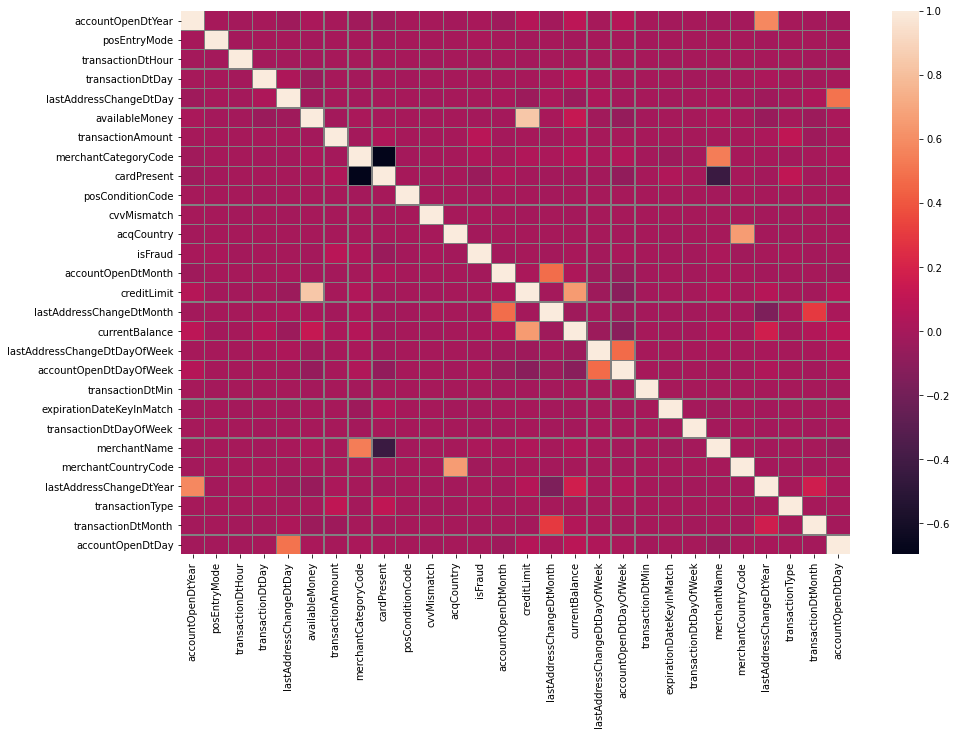

In [13]:
from seaborn import heatmap
import numpy as np

plt.rcParams['figure.figsize'] = (15,10)
columns_for_heatmap = set(main_df.columns) - set(['customerId', 'accountNumber', 'cardCVV', 'enteredCVV', 'cardLast4Digits'])
correlation_matrix = main_df[columns_for_heatmap].corr()
heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, 
        linewidths=0.25, linecolor='grey')
plt.show()

### Defining the Feature-set and Label-set to derive the train-test splits

In [14]:
flip_binary = lambda x: 1 if x==0 else 0
main_df['isFraud'] = main_df['isFraud'].apply(flip_binary)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, r2_score, accuracy_score, precision_score, recall_score

feature_cols = set(main_df.columns) - set(['isFraud', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'accountNumber', 'customerId'])
labels = main_df['isFraud']
features = main_df[feature_cols]
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, stratify=labels)

In [20]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(n_jobs=-1, verbose=1).fit(x_train, y_train)
preds = logistic_model.predict(x_test)

print(f'R2 score for Logistic-Regression model = {r2_score(y_test, preds)}')
print(f'Confusion matrix for Logistic-Regression model \n= {confusion_matrix(y_test, preds)}\n')
print(f'Precision = {precision_score(y_test, preds)}.')
print(f'Recall = {recall_score(y_test, preds)}')
print(f'Accuracy= {accuracy_score(y_test, preds)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   24.5s finished


R2 score for Logistic-Regression model = -0.016047548291233227
Confusion matrix for Logistic-Regression model 
= [[    0  1242]
 [    0 77395]]

Precision = 0.9842059081602808.
Recall = 1.0
Accuracy= 0.9842059081602808


### Using a more complex Random-Forest model than baseline Logistic
Isolation Forest is known to work well with highly-unbalanced sparse datasets (resembling Anomaly detection).

In [21]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=150,  n_jobs=-1, verbose=1).fit(x_train, y_train)

preds = iso_forest.predict(x_test)
preds = np.where(preds==-1, 0, preds)

print(f'R2 score for Isolation-Forest model = {r2_score(y_test, preds)}')
print(f'Confusion matrix for Isolation-Forest model \n= {confusion_matrix(y_test, preds)}')
print(f'Precision = {precision_score(y_test, preds)}')
print(f'Recall = {recall_score(y_test, preds)}')
print(f'Accuracy= {accuracy_score(y_test, preds)}')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    6.1s remaining:   18.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    6.4s finished


R2 score for Isolation-Forest model = -11.58115559192502
Confusion matrix for Isolation-Forest model 
= [[  276   966]
 [14413 62982]]
Precision = 0.9848939763557891
Recall = 0.8137734995800763
Accuracy= 0.804430484377583


### Moving on to a final Light-Gradient-Boosting model
LGBClassifier is known to work well on sparse-datasets for classification.

We observe a Type-II error of 0%! There are no transactions that we wrongly predicted to be fraudulent.

In [22]:
from lightgbm import LGBMClassifier, plot_importance

lgbm = LGBMClassifier(num_leaves=40,
                      max_depth=-1,
                      learning_rate=0.05,
                      n_estimators=150,
                      min_split_gain=0.005,
                      min_child_weight=0.0005,
                      reg_alpha=0.5,
                      reg_lambda=0.5,
                      n_jobs=-1).fit(x_train, y_train)
preds = lgbm.predict(x_test)
pd.DataFrame(preds).value_counts()

print(f'R2 score for LGBoost model = {r2_score(y_test, preds)}')
print(f'Confusion matrix for LGBoost model \n= {confusion_matrix(y_test, preds)}')
print(f'Precision = {precision_score(y_test, preds)}')
print(f'Recall = {recall_score(y_test, preds)}')
print(f'Accuracy= {accuracy_score(y_test, preds)}')

R2 score for LGBoost model = 0.07475863356088186
Confusion matrix for LGBoost model 
= [[  113  1129]
 [    2 77393]]
Precision = 0.9856218639362216
Recall = 0.9999741585373733
Accuracy= 0.9856174574309803


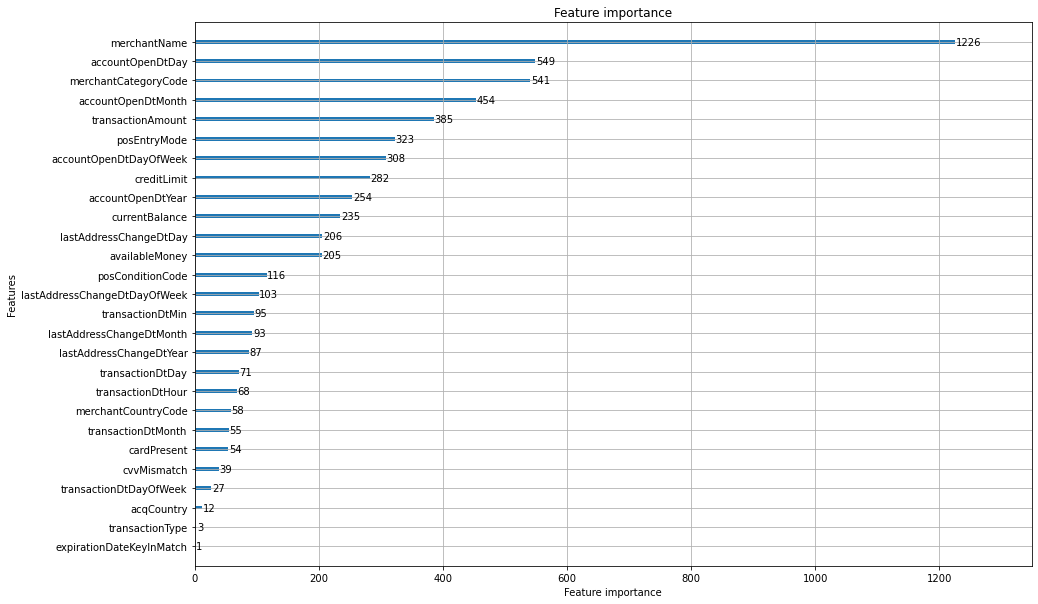

In [23]:
plot_importance(lgbm)
plt.show()